In [7]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
if ROOT.name == "research":
    ROOT = ROOT.parents[0]
CHAN = ROOT / "chan_data"

def _read_mmd(sym, tf):
    p = CHAN / "signals" / "mmd" / sym / f"{tf}_mmd123.csv"
    df = pd.read_csv(p, parse_dates=["ts","ref_ts"])
    df["ts"] = pd.to_datetime(df["ts"], utc=True, errors="coerce")
    df["ref_ts"] = pd.to_datetime(df["ref_ts"], utc=True, errors="coerce")
    return df.sort_values("ts").reset_index(drop=True)

def _read_segments(sym, tf):
    p = CHAN / "segments" / "fast" / sym / f"{tf}_segments.csv"
    df = pd.read_csv(p, parse_dates=["timestamp_start","timestamp_end"])
    df["timestamp_start"] = pd.to_datetime(df["timestamp_start"], utc=True, errors="coerce")
    df["timestamp_end"]   = pd.to_datetime(df["timestamp_end"],   utc=True, errors="coerce")
    return df.sort_values("timestamp_start").reset_index(drop=True)

def _read_zs(sym, tf):
    p = CHAN / "zhongshu_hierarchy_fast" / sym / f"{tf}_L1.csv"
    if p.exists():
        df = pd.read_csv(p, parse_dates=["timestamp_start","timestamp_end"])
        df["timestamp_start"] = pd.to_datetime(df["timestamp_start"], utc=True, errors="coerce")
        df["timestamp_end"]   = pd.to_datetime(df["timestamp_end"],   utc=True, errors="coerce")
        for c in ("zs_low","zs_high"):
            if c not in df.columns: df[c] = np.nan
        return df.sort_values("timestamp_start").reset_index(drop=True)
    return pd.DataFrame(columns=["zs_index","timestamp_start","timestamp_end","zs_low","zs_high"])

def _attach_segment(mmd: pd.DataFrame, seg: pd.DataFrame) -> pd.DataFrame:
    out = mmd.copy()


    for c in ["seg_index","seg_start","seg_end","seg_dir"]:
        if c not in out.columns:
            out[c] = pd.NA
    out["seg_start"] = pd.Series(pd.NaT, index=out.index, dtype="datetime64[ns, UTC]")
    out["seg_end"]   = pd.Series(pd.NaT, index=out.index, dtype="datetime64[ns, UTC]")

    if out.empty or seg.empty or "ref_ts" not in out.columns:
        return out

    seg = seg.sort_values("timestamp_start").reset_index(drop=True).copy()


    seg_start = pd.to_datetime(seg["timestamp_start"], utc=True, errors="coerce")
    seg_end   = pd.to_datetime(seg["timestamp_end"],   utc=True, errors="coerce")
    ref_ts    = pd.to_datetime(out["ref_ts"],          utc=True, errors="coerce")

    pos_np = seg_start.searchsorted(ref_ts, side="right") - 1
    pos = pd.Series(pos_np, index=out.index)  # 关键：做成 Series 以便索引对齐

    valid = pos >= 0

    cand_end = pd.Series(pd.NaT, index=out.index, dtype="datetime64[ns, UTC]")
    cand_end.loc[valid] = seg_end.iloc[pos.loc[valid]].array  # 用 .array 保留 tz

    hit = valid & (ref_ts <= cand_end)

    try:
        out.loc[hit, "seg_index"] = pos.loc[hit].astype("Int64")
    except TypeError:
        out.loc[hit, "seg_index"] = pos.loc[hit].astype("int64")

    out.loc[hit, "seg_start"] = seg_start.iloc[pos.loc[hit]].array
    out.loc[hit, "seg_end"]   = seg_end.iloc[pos.loc[hit]].array
    if "direction" in seg.columns:
        out.loc[hit, "seg_dir"] = seg["direction"].iloc[pos.loc[hit]].to_numpy(object)

    return out

def _attach_zs(mmd: pd.DataFrame, zs: pd.DataFrame, band_ratio=0.0) -> pd.DataFrame:

    out = mmd.copy()
    if out.empty or zs.empty or "zs_index" not in out.columns:
        for c in ["zs_start","zs_end","zs_low","zs_high","zs_state","zs_dist"]:
            out[c] = pd.NA
        return out

    z = zs.copy()

    if "zs_index" not in z.columns:
        if "index" in z.columns:
            z = z.rename(columns={"index":"zs_index"})
        else:
            z["zs_index"] = np.arange(len(z))

    merged = out.merge(
        z[["zs_index","timestamp_start","timestamp_end","zs_low","zs_high"]],
        how="left", on="zs_index", suffixes=("","")
    )
    merged = merged.rename(columns={
        "timestamp_start":"zs_start","timestamp_end":"zs_end"
    })

    for c in ("zs_low","zs_high"):
        if c not in merged.columns: merged[c] = np.nan

    mid = 0.5*(merged["zs_low"].astype(float) + merged["zs_high"].astype(float))
    band = mid * float(band_ratio)

    px = merged.get("ref_price", merged.get("price", np.nan)).astype(float)
    cond_above = px > (merged["zs_high"].astype(float) + band)
    cond_below = px < (merged["zs_low"].astype(float)  - band)
    state = np.where(cond_above, "above", np.where(cond_below, "below", "inside"))
    dist = np.where(
        state=="inside",
        np.minimum(merged["zs_high"].astype(float)-px, px-merged["zs_low"].astype(float))/np.maximum(1e-9, mid),
        np.where(state=="above", (px-merged["zs_high"].astype(float))/np.maximum(1e-9, mid),
                 (merged["zs_low"].astype(float)-px)/np.maximum(1e-9, mid))
    )
    merged["zs_state"] = state
    merged["zs_dist"]  = dist.astype(float)
    return merged

def explain_signals(sym="BTCUSDT", tf="15m", score_min=None, top_k=20, save_csv=True):
    mmd = _read_mmd(sym, tf)
    seg = _read_segments(sym, tf)
    zs  = _read_zs(sym, tf)

    d = mmd.copy()
    if score_min is not None and "score" in d.columns:
        d = d[d["score"] >= float(score_min)]
    if top_k:
        d = d.sort_values(["ts","side"]).tail(top_k)

    d = _attach_segment(d, seg)
    d = _attach_zs(d, zs, band_ratio=0.002)

    def _mk_reason(r):
        bits = []
        if pd.notna(r.get("zs_state")):
            bits.append(f"zs:{r['zs_state']}")
        if pd.notna(r.get("seg_dir")):
            bits.append(f"seg:{r['seg_dir']}")
        if pd.notna(r.get("score")):
            bits.append(f"score:{float(r['score']):.2f}")
        return ";".join(bits)

    d["reason"] = d.apply(_mk_reason, axis=1)

    cols = [
        "ts","side","tag","price","score",
        "ref_ts","ref_price",
        "seg_index","seg_start","seg_end","seg_dir",
        "zs_index","zs_start","zs_end","zs_low","zs_high","zs_state","zs_dist",
        "reason"
    ]
    for c in cols:
        if c not in d.columns: d[c] = pd.NA
    d = d[cols].sort_values("ts").reset_index(drop=True)

    if save_csv:
        out_dir = CHAN / "signals" / "explain" / sym
        out_dir.mkdir(parents=True, exist_ok=True)
        p = out_dir / f"{tf}_mmd_explain.csv"
        d.to_csv(p, index=False)
        print(f"[EXPLAIN] {sym}-{tf}: {len(d)} -> {p}")
    return d

def plot_signal(sym="BTCUSDT", tf="15m", row=None, lookback=100, lookforward=50):

    k = pd.read_csv(ROOT/"DATA"/sym/f"{tf}.csv")
    ts = pd.to_datetime(k["timestamp"], utc=True, errors="coerce")
    k["timestamp"] = ts
    k = k.dropna(subset=["timestamp"]).sort_values("timestamp").reset_index(drop=True)

    exp = explain_signals(sym, tf, top_k=0, save_csv=False)
    if isinstance(row, int):
        s = exp.iloc[row]
    else:
        s = row

    t0 = pd.to_datetime(s["ts"], utc=True, errors="coerce")
    idx = ts.searchsorted(t0)
    a = max(0, idx - lookback); b = min(len(k)-1, idx + lookforward)
    win = k.iloc[a:b+1].copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(win["timestamp"], win["close"], label="close")


    if pd.notna(s.get("ref_ts")):
        ax.axvline(pd.to_datetime(s["ref_ts"]), linestyle="--", alpha=0.6, label="ref_ts")
    ax.axvline(pd.to_datetime(s["ts"]), color="k", alpha=0.8, label="signal ts")

    if pd.notna(s.get("seg_start")) and pd.notna(s.get("seg_end")):
        ax.axvspan(pd.to_datetime(s["seg_start"]), pd.to_datetime(s["seg_end"]),
                   alpha=0.10, label="segment", ymin=0, ymax=1)

    if pd.notna(s.get("zs_low")) and pd.notna(s.get("zs_high")):
        ax.hlines([float(s["zs_low"]), float(s["zs_high"])],
                  xmin=win["timestamp"].iloc[0], xmax=win["timestamp"].iloc[-1],
                  linestyles="dotted", alpha=0.6, label="zs band")

    ax.set_title(f"{sym}-{tf}  {s['side']} {s['tag']}  score={s.get('score')}")
    ax.legend(loc="best")
    ax.grid(True)
    plt.show()

_ = explain_signals("BTCUSDT", "15m", score_min=2.0, top_k=30, save_csv=True)


[EXPLAIN] BTCUSDT-15m: 29 -> /Users/cc/PycharmProjects/ChanLab/chan_data/signals/explain/BTCUSDT/15m_mmd_explain.csv


In [9]:
import pandas as pd
from pathlib import Path

p = Path("/Users/cc/PycharmProjects/ChanLab/chan_data/signals/explain/BTCUSDT/15m_mmd_explain.csv")
df = pd.read_csv(p, parse_dates=["ts","ref_ts","seg_start","seg_end","zs_start","zs_end"])

view = (
    df.sort_values(["ts","score"], ascending=[True, False])
      .tail(30)[
        ["ts","side","tag","price","score","ref_ts","seg_index","seg_dir",
         "zs_index","zs_state","zs_low","zs_high","reason"]
      ]
      .reset_index(drop=True)
)

pd.set_option("display.max_rows", 50)
pd.set_option("display.max_colwidth", 120)
view


ts  side tag      price     score ref_ts  seg_index  \
0  2025-03-31 00:45:00+00:00   buy  1B   81646.89  3.210489    NaT        NaN   
1  2025-04-07 07:00:00+00:00   buy  1B   75087.87  2.835509    NaT        NaN   
2  2025-04-13 01:30:00+00:00  sell  1S   85726.99  3.398355    NaT        NaN   
3  2025-04-15 14:00:00+00:00  sell  1S   85774.51  3.624024    NaT        NaN   
4  2025-04-25 12:00:00+00:00  sell  1S   94802.52  3.400000    NaT        NaN   
5  2025-05-06 14:00:00+00:00   buy  1B   94046.37  2.734153    NaT        NaN   
6  2025-05-07 01:00:00+00:00  sell  1S   97480.16  3.183900    NaT        NaN   
7  2025-05-09 07:45:00+00:00  sell  1S  103628.77  3.657833    NaT        NaN   
8  2025-05-18 05:30:00+00:00   buy  1B  103490.64  3.343538    NaT        NaN   
9  2025-05-18 14:45:00+00:00  sell  1S  105270.97  3.400000    NaT        NaN   
10 2025-05-22 17:30:00+00:00  sell  1S  111749.99  2.500544    NaT        NaN   
11 2025-06-12 04:30:00+00:00   buy  1B  107594.82  2.579842    NaT        NaN   
12 2025-06-18 20:00:00+00:00   buy  1B  103811.09  3.235263    NaT        NaN   
13 2025-06-20 14:15:00+00:00  sell  1S  105300.38  2.809223    NaT        NaN   
14 2025-06-21 21:45:00+00:00   buy  1B  101455.61  3.400000    NaT        NaN   
15 2025-07-03 09:45:00+00:00  sell  1S  109942.20  2.877691    NaT        NaN   
16 2025-07-04 13:30:00+00:00  sell  1S  108367.00  4.000000    NaT        NaN   
17 2025-07-16 21:00:00+00:00  sell  1S  119901.16  2.828340    NaT        NaN   
18 2025-07-20 22:15:00+00:00   buy  1B  117266.00  3.400000    NaT        NaN   
19 2025-07-27 16:30:00+00:00  sell  1S  119312.34  3.207803    NaT        NaN   
20 2025-08-02 19:00:00+00:00   buy  1B  112046.90  3.400000    NaT        NaN   
21 2025-08-06 14:30:00+00:00   buy  1B  114300.96  2.564652    NaT        NaN   
22 2025-08-13 14:00:00+00:00  sell  1S  122070.75  3.400000    NaT        NaN   
23 2025-08-25 00:45:00+00:00   buy  1B  112645.10  3.400000    NaT        NaN   
24 2025-08-29 07:00:00+00:00  sell  1S  110545.00  3.783931    NaT        NaN   
25 2025-08-30 02:00:00+00:00   buy  1B  107774.78  3.340000    NaT        NaN   
26 2025-09-24 04:00:00+00:00   buy  1B  111475.67  4.000000    NaT        NaN   
27 2025-10-03 16:30:00+00:00  sell  1S  123778.33  2.600000    NaT        NaN   
28 2025-10-05 05:30:00+00:00  sell  1S  125229.99  2.833004    NaT        NaN   

    seg_dir  zs_index zs_state  zs_low  zs_high                reason  
0       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.21  
1       NaN       NaN   inside     NaN      NaN  zs:inside;score:2.84  
2       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
3       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.62  
4       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
5       NaN       NaN   inside     NaN      NaN  zs:inside;score:2.73  
6       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.18  
7       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.66  
8       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.34  
9       NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
10      NaN       NaN   inside     NaN      NaN  zs:inside;score:2.50  
11      NaN       NaN   inside     NaN      NaN  zs:inside;score:2.58  
12      NaN       NaN   inside     NaN      NaN  zs:inside;score:3.24  
13      NaN       NaN   inside     NaN      NaN  zs:inside;score:2.81  
14      NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
15      NaN       NaN   inside     NaN      NaN  zs:inside;score:2.88  
16      NaN       NaN   inside     NaN      NaN  zs:inside;score:4.00  
17      NaN       NaN   inside     NaN      NaN  zs:inside;score:2.83  
18      NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
19      NaN       NaN   inside     NaN      NaN  zs:inside;score:3.21  
20      NaN       NaN   inside     NaN      NaN  zs:inside;score:3.40  
21      NaN

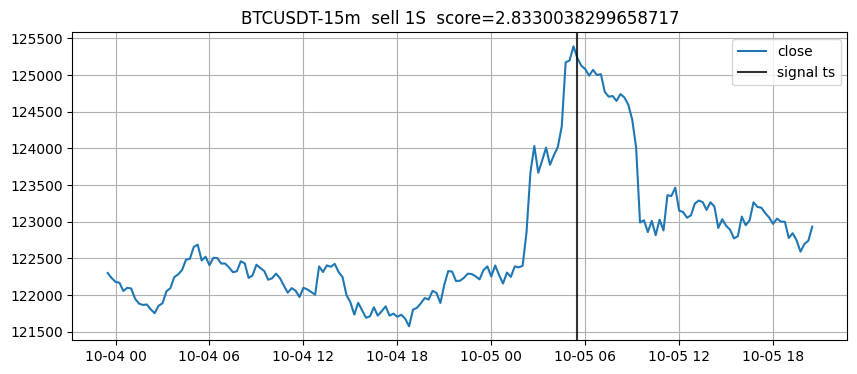

In [10]:
row_to_plot = view.iloc[-1]
plot_signal("BTCUSDT", "15m", row=row_to_plot, lookback=120, lookforward=60)

In [13]:
# === Research Question 02: Explainability ===
# Cell 2 – Inspect explainable signals and visualize one example

from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt

# 1️载入 explain CSV
p = Path("/Users/cc/PycharmProjects/ChanLab/chan_data/signals/explain/BTCUSDT/15m_mmd_explain.csv")
df_exp = pd.read_csv(p, parse_dates=["ts", "ref_ts"])
print(f"[Explain] {len(df_exp)} signals loaded from {p}")
df_exp.head(10)[["ts","side","tag","score","seg_dir","zs_state","reason"]]


[Explain] 29 signals loaded from /Users/cc/PycharmProjects/ChanLab/chan_data/signals/explain/BTCUSDT/15m_mmd_explain.csv


ts  side tag     score  seg_dir zs_state  \
0 2025-03-31 00:45:00+00:00   buy  1B  3.210489      NaN   inside   
1 2025-04-07 07:00:00+00:00   buy  1B  2.835509      NaN   inside   
2 2025-04-13 01:30:00+00:00  sell  1S  3.398355      NaN   inside   
3 2025-04-15 14:00:00+00:00  sell  1S  3.624024      NaN   inside   
4 2025-04-25 12:00:00+00:00  sell  1S  3.400000      NaN   inside   
5 2025-05-06 14:00:00+00:00   buy  1B  2.734153      NaN   inside   
6 2025-05-07 01:00:00+00:00  sell  1S  3.183900      NaN   inside   
7 2025-05-09 07:45:00+00:00  sell  1S  3.657833      NaN   inside   
8 2025-05-18 05:30:00+00:00   buy  1B  3.343538      NaN   inside   
9 2025-05-18 14:45:00+00:00  sell  1S  3.400000      NaN   inside   

                 reason  
0  zs:inside;score:3.21  
1  zs:inside;score:2.84  
2  zs:inside;score:3.40  
3  zs:inside;score:3.62  
4  zs:inside;score:3.40  
5  zs:inside;score:2.73  
6  zs:inside;score:3.18  
7  zs:inside;score:3.66  
8  zs:inside;score:3.34  
9  zs:inside;score:3.40

[Explain] 29 signals loaded from /Users/cc/PycharmProjects/ChanLab/chan_data/signals/explain/BTCUSDT/15m_mmd_explain.csv


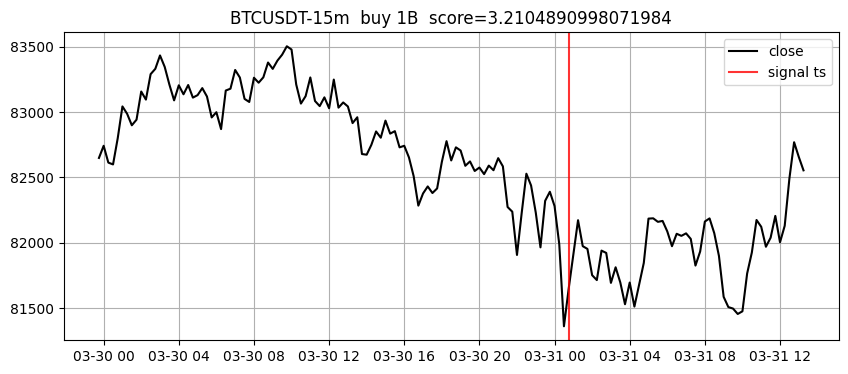

In [15]:
# === Research Question 02: Explainability ===
# Cell 2 – inspect explainable signals and visualize one example

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

ROOT = Path.cwd().resolve()
if ROOT.name == "research":
    ROOT = ROOT.parents[0]

CHAN = ROOT / "chan_data"

def plot_signal(sym="BTCUSDT", tf="15m", row=0, lookback=100, lookforward=50):

    p_exp = CHAN / "signals" / "explain" / sym / f"{tf}_mmd_explain.csv"
    df_exp = pd.read_csv(p_exp, parse_dates=["ts","ref_ts"])
    if df_exp.empty:
        raise FileNotFoundError(f"Explain file empty: {p_exp}")
    if isinstance(row, int):
        s = df_exp.iloc[row]
    else:
        s = row

    p_k = ROOT / "DATA" / sym / f"{tf}.csv"
    df_k = pd.read_csv(p_k)
    df_k["timestamp"] = pd.to_datetime(df_k["timestamp"], utc=True, errors="coerce")
    df_k = df_k.sort_values("timestamp").reset_index(drop=True)

    t0 = pd.to_datetime(s["ts"], utc=True, errors="coerce")
    ts = df_k["timestamp"]
    idx = ts.searchsorted(t0)
    a = max(0, idx - lookback)
    b = min(len(df_k)-1, idx + lookforward)
    win = df_k.iloc[a:b+1].copy()

    fig, ax = plt.subplots(figsize=(10, 4))
    ax.plot(win["timestamp"], win["close"], label="close", color="black")

    if pd.notna(s.get("ref_ts")):
        ax.axvline(pd.to_datetime(s["ref_ts"]), linestyle="--", alpha=0.6, color="gray", label="ref_ts")
    ax.axvline(pd.to_datetime(s["ts"]), color="red", alpha=0.8, label="signal ts")

    if pd.notna(s.get("seg_start")) and pd.notna(s.get("seg_end")):
        ax.axvspan(pd.to_datetime(s["seg_start"]), pd.to_datetime(s["seg_end"]),
                   alpha=0.1, color="orange", label="segment zone")

    if pd.notna(s.get("zs_low")) and pd.notna(s.get("zs_high")):
        ax.hlines([float(s["zs_low"]), float(s["zs_high"])],
                  xmin=win["timestamp"].iloc[0], xmax=win["timestamp"].iloc[-1],
                  linestyles="dotted", colors="blue", alpha=0.6, label="Zhongshu band")

    ax.set_title(f"{sym}-{tf}  {s['side']} {s['tag']}  score={s.get('score')}")
    ax.legend(loc="best")
    ax.grid(True)
    plt.show()

p = CHAN / "signals" / "explain" / "BTCUSDT" / "15m_mmd_explain.csv"
df_exp = pd.read_csv(p, parse_dates=["ts", "ref_ts"])
print(f"[Explain] {len(df_exp)} signals loaded from {p}")
df_exp.head(10)[["ts","side","tag","score","seg_dir","zs_state","reason"]]

plot_signal("BTCUSDT", "15m", row=0)
